# Boxplot of DE junctions

In [1]:
library(ggpubr)
library(ggplot2)
library(tidyverse)
suppressMessages(library(data.table))

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.3     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
ggplot_save <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


subset_deg <- function(fn, thres){
    jt = fread(fn) %>% rename(Feature='V1') %>% 
        filter(adj.P.Val < thres) %>% 
        select(Feature, ensemblID, Symbol, logFC, adj.P.Val)
    return(jt)
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Load DEG annotation

In [3]:
fn1 = '../../_m/junctions/diffExpr_interaction_full.txt'
fn2 = '../../_m/junctions/diffExpr_maleVfemale_full.txt'
fn3 = '../../_m/junctions/diffExpr_szVctl_full.txt'
juncs = subset_deg(fn1, 0.05)
sex = subset_deg(fn2, 1)
sz = subset_deg(fn3, 1)

Warning message in fread(fn):
"Detected 24 column names but the data has 25 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in fread(fn):
"Detected 24 column names but the data has 25 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in fread(fn):
"Detected 24 column names but the data has 25 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to creat

In [4]:
df = juncs %>% 
        inner_join(sex, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Sex")) %>%
        inner_join(sz, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Diagnosis"))
df = add_symnum(df)
df

Feature,ensemblID,Symbol,logFC,adj.P.Val,logFC_Sex,adj.P.Val_Sex,logFC_Diagnosis,adj.P.Val_Diagnosis,FDR,p.signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr21:8401395-8445553(-),NA,NA,6.554975,4.771233e-07,0.1511442,9.998106e-01,-7.135246,7.207256e-12,4.8e-07,****
chr21:8401487-8445715(-),NA,NA,6.182875,4.771233e-07,0.0510124,9.998106e-01,-5.597443,4.694512e-08,4.8e-07,****
chr14:49566087-49586737(+),NA,NA,-5.045805,2.625632e-06,2.0704146,8.239378e-02,4.577893,6.842891e-09,2.6e-06,****
chr21:8401417-8445654(-),NA,NA,3.875863,2.625632e-06,-0.2302949,9.998106e-01,-3.456343,2.245048e-06,2.6e-06,****
chrM:2246-2357(+),NA,NA,4.512204,4.930970e-06,-2.6543742,1.589546e-05,-2.238889,1.144939e-01,4.9e-06,****
chrX:103785769-103786025(+),NA,NA,-3.534872,4.167734e-04,0.8464571,9.411460e-01,1.668645,2.025206e-01,0.00042,***
chr21:8401970-8446050(+),NA,NA,5.742911,1.220665e-03,-3.6242098,3.376376e-06,-4.277469,7.318895e-03,0.00122,**
chrM:2249-2291(+),NA,NA,3.859219,2.523787e-03,-1.6348623,4.815199e-01,-1.143782,6.519766e-01,0.00252,**
chr21:8218504-8401545(-),NA,NA,-3.818749,3.174590e-02,1.3602054,9.733131e-01,2.377718,1.843161e-01,0.03175,*


## Load phenotypes

In [5]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv'
pheno = fread(pheno_file) %>% column_to_rownames(var='V1') %>% 
    mutate_if(is.character, as.factor)
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL
2,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,SZ


## Load residualized expression

In [6]:
res_file = '../../_m/junctions/residualized_expression.tsv'
resdf = fread(res_file) %>% 
    column_to_rownames(var="V1") %>% t
resdf = as.data.frame(resdf) %>% 
    rownames_to_column() %>% 
    rename(RNum=rowname) %>% 
    select(RNum, df$Feature)
resdf[1:2, 1:3]

Warning message in fread(res_file):
"Detected 374 column names but the data has 375 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,RNum,chr21:8401395-8445553(-),chr21:8401487-8445715(-)
,<chr>,<dbl>,<dbl>
1,R10424,0.2521514,0.3165395
2,R12195,0.9396288,-0.5792814


## Merge data

In [7]:
jj = pheno %>% 
    inner_join(resdf, by='RNum')
jj %>% dim
jj[1:2, 1:10]

[1] 374  17

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,chr21:8401395-8445553(-),chr21:8401487-8445715(-)
,<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL,0.2521514,0.3165395
2,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,SZ,0.9396288,-0.5792814


In [8]:
dft = jj %>% pivot_longer(-c(BrNum, RNum, Region, RIN, Age, Sex, Race, Dx), 
                          names_to="Feature", values_to="Res") %>% 
    inner_join(df, by="Feature") %>% mutate_at("Feature", as.factor)
dft[1:2, 1:10]

BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,Feature,Res
<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>
Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL,chr21:8401395-8445553(-),0.2521514
Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL,chr21:8401487-8445715(-),0.3165395


Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


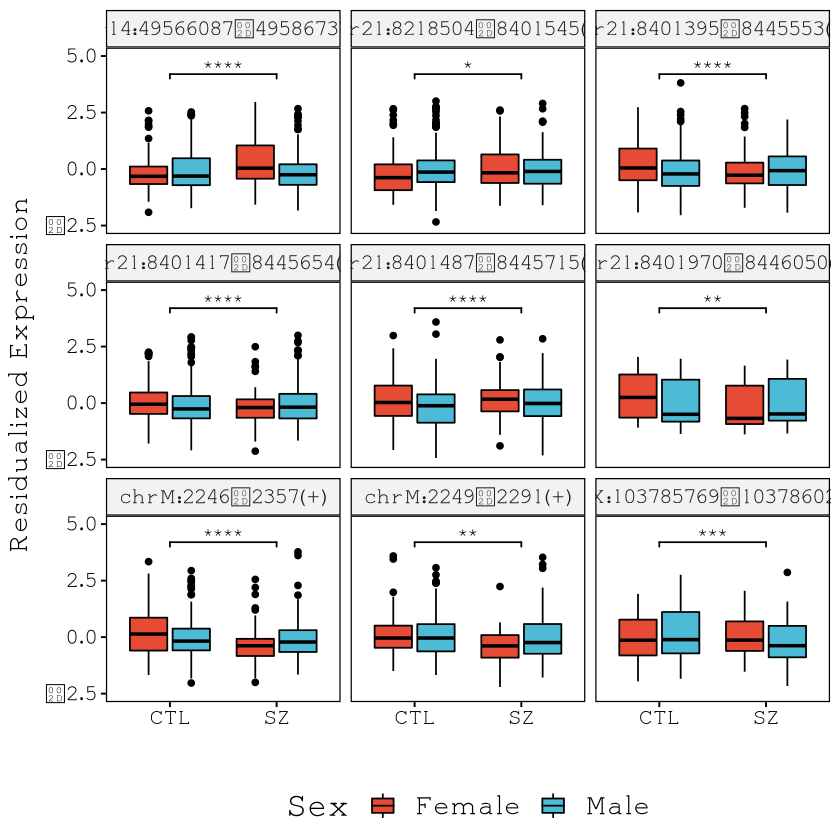

In [9]:
tmp = df %>% mutate(group1='CTL', group2='SZ', y_pos=4.2)

bxp <- ggboxplot(dft, x="Dx", y="Res", color="Sex", add='jitter',
                 ncol=3, outlier.shape=NA,
                 panel.labs.font=list(face='bold', size = 14),
                 facet.by=c("Feature"), palette="npg", xlab='', 
                 ylim=c(-2.5, 5), ylab='Residualized Expression', 
                 add.params=list(alpha=0.5), legend="bottom") +
        geom_signif(data=tmp, 
                    aes(xmin=group1, xmax=group2, 
                        annotations=p.signif, y_position=y_pos), 
                    manual=TRUE) + 
        font("xy.title", size=18, face="bold") + font("xy.text", size=14) + 
        font("legend.title", size=21, face="bold") + font("legend.text", size=18)
         
bxp

In [10]:
ggplot_save(bxp, 'junc_interaction', 12, 12)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()